This notebook trying to do Classification of MBTI type by text. 
There would be 
1. Data Visualization
2. Text Preprocessing 
3. Converting Text to numbers
4. Training and Test Sets
5. Training Test Classification Model and Predicting Sentiment
6. Evaluating the Model 

The data actually are not equal distributed from each types. Therefore, I will only use 4 types that representing 2 Extroverted and 2 Introverted. 

In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import plotly.express as px
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import spacy
import string
pd.options.mode.chained_assignment = None

from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mbti-type/mbti_1.csv


In [2]:
df = pd.read_csv('../input/mbti-type/mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [5]:
a = df.sort_values(by=["type"], ascending=True, inplace=False)
a

,type,posts
5777,ENFJ,'My friends say I flirt a lot. That I'm probab...
7976,ENFJ,'hmm... I think I should post my view of roman...
2851,ENFJ,'Not surprised since I get along with INTP guy...
342,ENFJ,'hahahahahaha. i just love my ability to read ...
1441,ENFJ,'You are such a good friend. She is lucky to ...
...,...,...
3524,ISTP,'You know your an ISTP female when you tell th...
123,ISTP,'I don't offer advice unless it is asked for o...
3525,ISTP,'.|||Thank you. It's the first time I've tried...
8419,ISTP,"'I agree with Seralya, message him that, and t..."


## Data Visualization

In this section, I will visualize all data and then scrap 4 types that equally distributed to be used in this notebook. 

<AxesSubplot:xlabel='type', ylabel='count'>

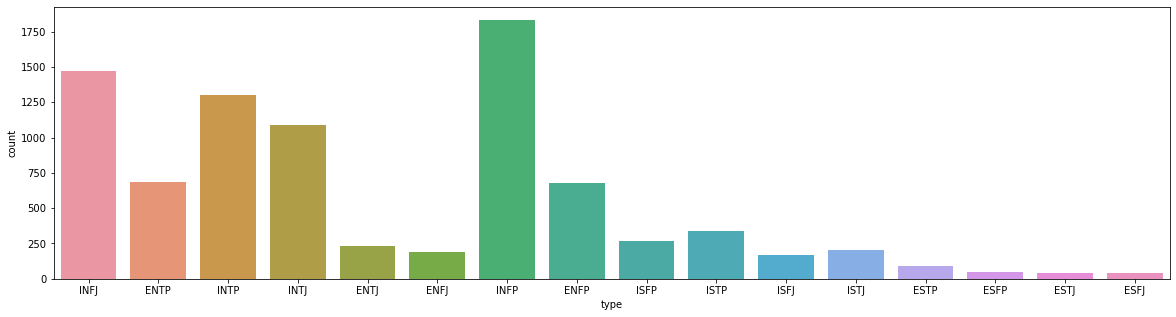

In [8]:
fig = plt.gcf()
fig.set_size_inches(20, 5)
sns.countplot(x="type", data = df)

In [13]:
grouped_data = df.groupby(['type']).size().reset_index()
grouped_data.columns = ['type','Count']
grouped_data = grouped_data.sort_values('Count', ascending = True)
fig = px.bar(grouped_data, x = 'type', y = 'Count', title = 'Distribution Of Each Types')
fig.show()

In [15]:
a = df.groupby('type').agg({'type':'count'})
a

,type
type,
ENFJ,190
ENFP,675
ENTJ,231
ENTP,685
ESFJ,42
ESFP,48
ESTJ,39
ESTP,89
INFJ,1470


This is the process of dropping down the data that we would not use.

In [10]:
b = df[~(df.type.isin(['ESTJ','ESFJ','ESFP', 'ESTP', 'ISFP', 'ISTP', 'ENFP','ENTP','INTJ','INTP','INFJ','INFP']))]
b

,type,posts
4,ENTJ,'You're fired.|||That's another silly misconce...
11,ENFJ,'https://www.youtube.com/watch?v=PLAaiKvHvZs||...
22,ENTJ,'Now I'm interested. But too lazy to go resear...
24,ENTJ,'Still going strong at just over the two year ...
34,ENFJ,https://www.youtube.com/watch?v=AwgF14ySLpw I...
...,...,...
8618,ENTJ,"'Yeah, except I lie a lot, especially to peopl..."
8622,ISFJ,'I've never thought of starting a dream journa...
8632,ISTJ,I'm always for inflating my ego - Energy Drin...
8652,ISFJ,'Being assertive and standing up for myself is...


In [16]:
grouped_data = b.groupby(['type']).size().reset_index()
grouped_data.columns = ['type','Count']
grouped_data = grouped_data.sort_values('Count', ascending = True)
fig = px.bar(grouped_data, x = 'type', y = 'Count', title = 'Distribution of ISFJ, ENFJ, ISTJ, ENTJ')
fig.show()

In [26]:
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

b['words_per_comment'] = b['posts'].apply(lambda x: len(x.split())/50)
b['variance_of_word_counts'] = b['posts'].apply(lambda x: var_row(x))
b.head()

,type,posts,words_per_comment,variance_of_word_counts
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.457600
11,ENFJ,'https://www.youtube.com/watch?v=PLAaiKvHvZs||...,15.94,269.087074
22,ENTJ,'Now I'm interested. But too lazy to go resear...,23.84,157.747600
24,ENTJ,'Still going strong at just over the two year ...,21.72,198.730000
34,ENFJ,https://www.youtube.com/watch?v=AwgF14ySLpw I...,20.54,176.609600


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='type', ylabel='words_per_comment'>

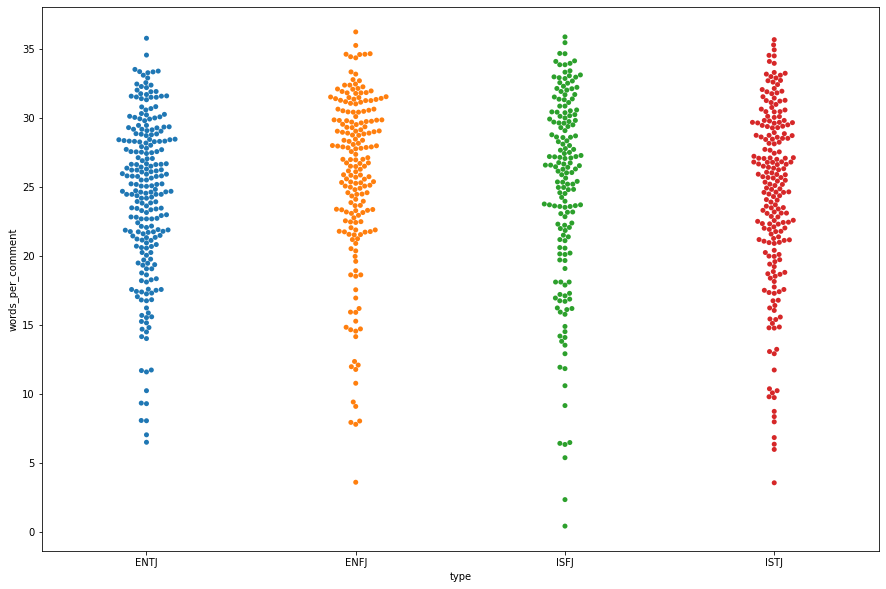

In [19]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "words_per_comment", data=b)

## **Text Preprocessing**

In this section, remove all the special characters, numbers, and unwanted spaces from our text.

In [52]:
##### Compute list of subject with Type | list of comments 
from nltk.stem import PorterStemmer, WordNetLemmatizer

unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
  
unique_type_list = [x.lower() for x in unique_type_list]

# Lemmatize
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

def pre_process_data(b, remove_stop_words=True):

    list_personality = []
    list_posts = []
    len_data = len(b)
    i=0
    
    for row in b.iterrows():
        i+=1
        if i % 500 == 0:
            print("%s | %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'link', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])

        type_labelized = lab_encoder.transform([row[1].type])[0]
        list_personality.append(type_labelized)
        list_posts.append(temp)

    #del data
    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

list_posts, list_personality = pre_process_data(b, remove_stop_words=True)

500 | 792 rows


In [54]:
print("Num posts and personalities: ",  list_posts.shape, list_personality.shape)

Num posts and personalities:  (792,) (792,)


In [53]:
list_posts[0]

' fired another silly misconception approaching logically going key unlocking whatever think entitled nobody want approached b guy really want go super duper long as vacation c mon guy bos listen get even approached logically everything never mind go permanent vacation two month crazy idea really best employee may cooking want reliable asset gone long entj employer lol like view unsolicited victim sometimes really like impoverished rap music link probably would lost stonewalling insignificant idiot semantics impact anything one thing stone wall critical shit would taken project gave something later court deposition skit actually happened verbatim reenactment as flirt woman piece candy grocery store course use whatever disposal get want efficient manner possible mean flirting link yes comment gave info shut went crush bos wanted know impress bos married interested thing callaendia infp girl entj facebook forum similar question ask time close together scenario similar x modify suit other

## **Converting Text to Numbers**

In [56]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

# Posts to a matrix of token counts
cntizer = CountVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
                             max_df=0.7,
                             min_df=0.1) 

# Learn the vocabulary dictionary and return term-document matrix
print("CountVectorizer...")
X_cnt = cntizer.fit_transform(list_posts)

# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

print("Tf-idf...")
# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()

CountVectorizer...
Tf-idf...


In [57]:
feature_names = list(enumerate(cntizer.get_feature_names()))
feature_names

[(0, 'ability'),
 (1, 'able'),
 (2, 'absolutely'),
 (3, 'accept'),
 (4, 'according'),
 (5, 'accurate'),
 (6, 'across'),
 (7, 'act'),
 (8, 'action'),
 (9, 'actually'),
 (10, 'add'),
 (11, 'admit'),
 (12, 'advice'),
 (13, 'affect'),
 (14, 'afraid'),
 (15, 'age'),
 (16, 'ago'),
 (17, 'agree'),
 (18, 'ah'),
 (19, 'almost'),
 (20, 'alone'),
 (21, 'along'),
 (22, 'already'),
 (23, 'although'),
 (24, 'amazing'),
 (25, 'amount'),
 (26, 'angry'),
 (27, 'animal'),
 (28, 'annoying'),
 (29, 'another'),
 (30, 'answer'),
 (31, 'anymore'),
 (32, 'anyone'),
 (33, 'anything'),
 (34, 'anyway'),
 (35, 'apparently'),
 (36, 'appreciate'),
 (37, 'approach'),
 (38, 'area'),
 (39, 'argument'),
 (40, 'around'),
 (41, 'art'),
 (42, 'ask'),
 (43, 'asked'),
 (44, 'asking'),
 (45, 'aspect'),
 (46, 'attention'),
 (47, 'attracted'),
 (48, 'avatar'),
 (49, 'avoid'),
 (50, 'aware'),
 (51, 'away'),
 (52, 'awesome'),
 (53, 'awkward'),
 (54, 'back'),
 (55, 'bad'),
 (56, 'based'),
 (57, 'basically'),
 (58, 'beautiful'),
 

## **Text Preprocessing Version 2**

In [65]:
def preprocess_inputs(df):
    
    texts = b['posts'].copy()
    labels = b['type'].copy()
    
    # Process text data
    stop_words = stopwords.words('english')
    
    texts = [text.lower() for text in texts]
    texts = [text.split() for text in texts]
    texts = [[word.strip() for word in text] for text in texts]
    texts = [[word for word in text if word not in stop_words] for text in texts]
    
    vocab_length = 10000
    
    tokenizer = Tokenizer(num_words=vocab_length)
    tokenizer.fit_on_texts(texts)
    
    texts = tokenizer.texts_to_sequences(texts)
    
    max_seq_length = np.max([len(text) for text in texts])
    
    texts = pad_sequences(texts, maxlen=max_seq_length, padding='post')
    
    # Process label data
    label_values = ['ENTJ', 'ENFJ', 'ISFJ', 'ISTJ']
    
    label_mapping = {label: np.int(label[0] == 'E') for label in label_values}
    
    labels = labels.replace(label_mapping)
    labels = np.array(labels)
    
    return texts, labels, max_seq_length, vocab_length, label_mapping

In [66]:
texts, labels, max_seq_length, vocab_length, label_mapping = preprocess_inputs(b)

In [67]:
print("Text sequences:\n", texts.shape)
print("\nLabels:\n", labels.shape)
print("\nMax sequence length:\n", max_seq_length)
print("\nVocab length:\n", vocab_length)
print("\nLabel mapping:\n", label_mapping)

Text sequences:
 (792, 803)

Labels:
 (792,)

Max sequence length:
 803

Vocab length:
 10000

Label mapping:
 {'ENTJ': 1, 'ENFJ': 1, 'ISFJ': 0, 'ISTJ': 0}


## **Training and Testing Sets**

In [68]:
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, train_size=0.7, random_state=123)

In [69]:
texts

array([[8833,  131, 1347, ...,    0,    0,    0],
       [ 229,  506,  350, ...,    0,    0,    0],
       [   2, 2740, 1195, ...,    0,    0,    0],
       ...,
       [   2,   22, 1874, ...,    0,    0,    0],
       [3440, 2111,   21, ...,    0,    0,    0],
       [ 851,  123,   22, ...,    0,    0,    0]], dtype=int32)

## **Training Text Classification Model and Predicting Sentiment**

In [72]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(texts_train, labels_train) 

RandomForestClassifier(n_estimators=1000, random_state=0)

In [73]:
labels_pred = classifier.predict(texts_test)

## **Evaluating The Model**

In [74]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(labels_test,labels_pred))
print(classification_report(labels_test,labels_pred))
print(accuracy_score(labels_test, labels_pred))

[[ 10 110]
 [ 10 108]]
              precision    recall  f1-score   support

           0       0.50      0.08      0.14       120
           1       0.50      0.92      0.64       118

    accuracy                           0.50       238
   macro avg       0.50      0.50      0.39       238
weighted avg       0.50      0.50      0.39       238

0.4957983193277311


The accuracy only 45%. Let's try with another RNN using TensorFlow

**RNN using TensorFlow**

In [75]:
embedding_dim = 512

inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(inputs)

gru = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(
        units=256,
        return_sequences=True
    )
)(embedding)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)


model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


history = model.fit(
    texts_train,
    labels_train,
    validation_split=0.2,
    batch_size=32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('./model.h5', save_best_only=True, save_weights_only=True)
    ]
)

Epoch 1/5
14/14 [==============================] - 69s 5s/step - loss: 0.8255 - accuracy: 0.4945 - auc: 0.4856 - val_loss: 0.7905 - val_accuracy: 0.4414 - val_auc: 0.5079
Epoch 2/5
14/14 [==============================] - 70s 5s/step - loss: 0.3074 - accuracy: 0.8953 - auc: 0.9972 - val_loss: 0.7211 - val_accuracy: 0.4595 - val_auc: 0.5884
Epoch 3/5
14/14 [==============================] - 61s 4s/step - loss: 0.0589 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.6916 - val_accuracy: 0.5315 - val_auc: 0.6610
Epoch 4/5
14/14 [==============================] - 62s 4s/step - loss: 0.0122 - accuracy: 0.9962 - auc: 1.0000 - val_loss: 0.6829 - val_accuracy: 0.5495 - val_auc: 0.7110
Epoch 5/5
14/14 [==============================] - 59s 4s/step - loss: 0.0032 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.7485 - val_accuracy: 0.5225 - val_auc: 0.7161


In [76]:
model.load_weights('./model.h5')

In [77]:
model.evaluate(texts_test, labels_test)

8/8 [==============================] - 8s 932ms/step - loss: 0.5852 - accuracy: 0.6807 - auc: 0.8469


[0.585170567035675, 0.680672287940979, 0.8468573093414307]

The accuracy using RNN is 68%